# RNA Data Preprocessing Before Integration

## Content

Here we just use the basic steps to preprocess RNA data following the [scanpy tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html). We also select 

### Dataset used in this demo

The dataset we used were downloaded from [Allen Brain Institiute](https://portal.brain-map.org/atlases-and-data/rnaseq/mouse-whole-cortex-and-hippocampus-smart-seq). The original dataset includes single-cell transcriptomes (SMART-seq) from multiple cortical areas and the hippocampal formation, including 76,533 total cells. Samples were collected from dissections of brain regions from ~8 week-old male and female mice, primarily from pan-GABAergic, pan-glutamatergic, and pan-neuronal transgenic lines. **We select 8517 cells from MOp and CA region to match the snmC-seq2 demo dataset**.

In [1]:
import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ALLCools.clustering import significant_pc_test
from ALLCools.plot import categorical_scatter

In [2]:
adata_path = '../../data/Brain/MOp+CA.SMART-seq.ABI.h5ad'
min_genes = 200
min_cells = 5

# HVG
min_mean = 0.0125
max_mean = 3
n_top_genes = 2000

## Load

In [3]:
# The adata.X is the raw exon+intron counts
adata = anndata.read_h5ad(adata_path)
adata

AnnData object with n_obs × n_vars = 8517 × 24446
    obs: 'cluster_color', 'cluster_order', 'cluster_label', 'class_color', 'class_order', 'class_label', 'subclass_color', 'subclass_order', 'subclass_label', 'full_genotype_color', 'full_genotype_order', 'full_genotype_label', 'donor_sex_color', 'donor_sex_order', 'donor_sex_label', 'region_color', 'region_order', 'region_label', 'cortical_layer_color', 'cortical_layer_order', 'cortical_layer_label', 'cell_type_accession_color', 'cell_type_accession_order', 'cell_type_accession_label', 'cell_type_alias_color', 'cell_type_alias_order', 'cell_type_alias_label', 'cell_type_alt_alias_color', 'cell_type_alt_alias_order', 'cell_type_alt_alias_label', 'cell_type_designation_color', 'cell_type_designation_order', 'cell_type_designation_label', 'external_donor_name_color', 'external_donor_name_order', 'external_donor_name_label', 'facs_population_plan_color', 'facs_population_plan_order', 'facs_population_plan_label', 'injection_materials_color

## Preprocessing

In [4]:
sc.pp.filter_cells(adata, min_genes=min_genes)
sc.pp.filter_genes(adata, min_cells=min_cells)

sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)

/home/hanliu/.local/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


## Select HVG

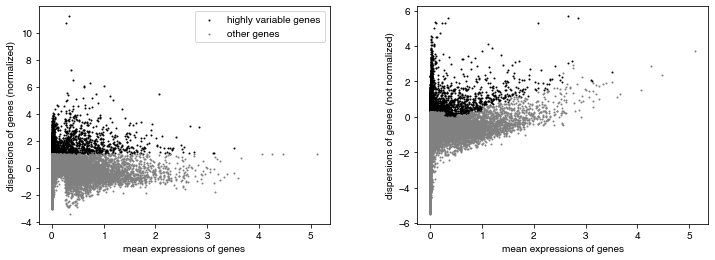

In [5]:
sc.pp.highly_variable_genes(adata, min_mean=min_mean, max_mean=max_mean, n_top_genes=n_top_genes)
sc.pl.highly_variable_genes(adata)

In [6]:
# apply the HVG selection
adata = adata[:, adata.var.highly_variable]

## Scale

In [7]:
sc.pp.scale(adata, max_value=10)

/home/hanliu/miniconda3/envs/allcools/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:806: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


## Save

In [8]:
adata.write_h5ad('RNA.norm.log1p.HVG.scale.h5ad')

## Sanity Test

Here we run a basic embedding to plot the cell types annodataed by the data providers, making sure the features we selected can separating the major cell types (Subclass level in their annotation) well. 

In [9]:
sc.tl.pca(adata, svd_solver='arpack')
significant_pc_test(adata, p_cutoff=0.1)

sc.pp.neighbors(adata, n_neighbors=20)
sc.tl.umap(adata)
adata.obs['umap_0'] = adata.obsm['X_umap'][:, 0]
adata.obs['umap_1'] = adata.obsm['X_umap'][:, 1]

45 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (8517, 50) to (8517, 45)


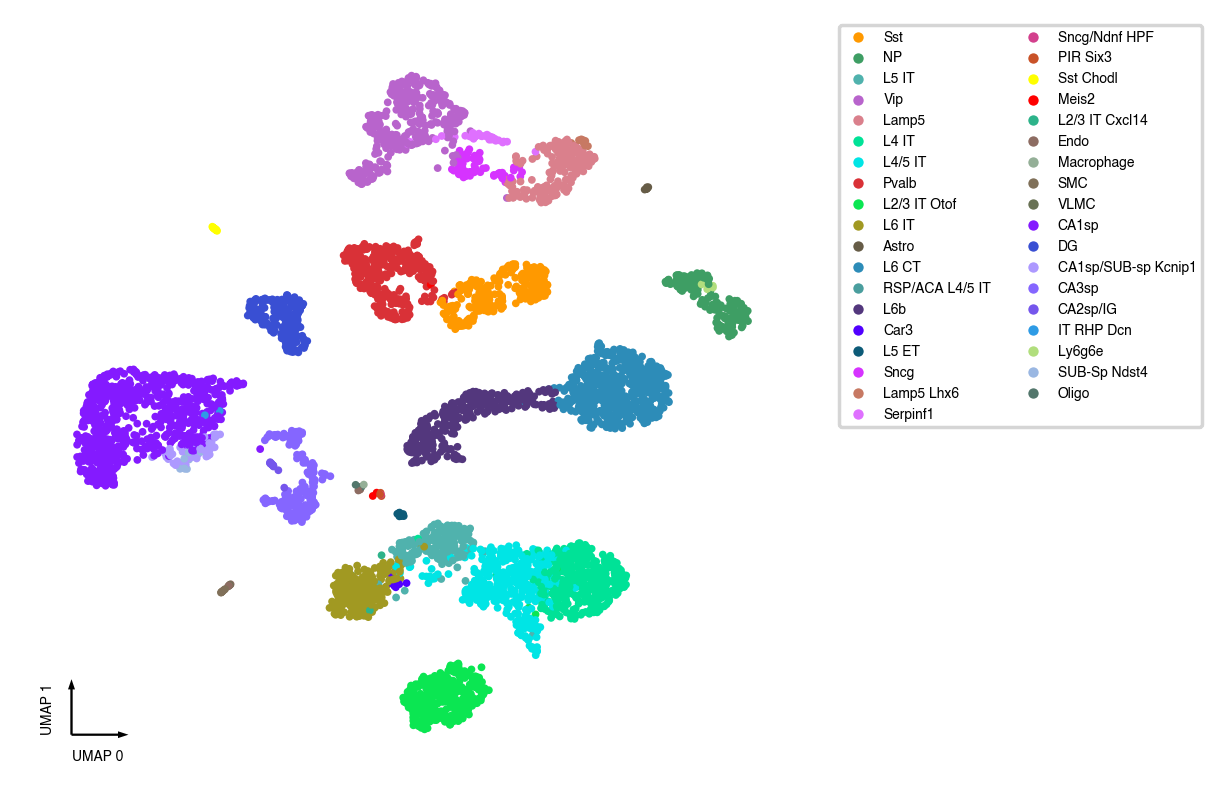

In [10]:
if 'subclass_label' in adata.obs:
    fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
    
    categorical_scatter(ax=ax,
                        data=adata.obs, 
                        hue='subclass_label',
                        palette = adata.obs.set_index('subclass_label')['subclass_color'].to_dict(),
                        show_legend=True)
    

With the top highly variable genes, the cluster annotated by data providers are separated reasonably well.